This notebook demonstrates using QISKit ACQUA Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule using VQE with different variation form configurations. The results are compared to the same energy as computed by the ExactEigensolver

This notebook populates a dictionary, that is a progammatic representation of an input file, in order to drive the qiskit_acqua_chemistry stack. Such a dictionary can be manipulated programmatically and this is indeed the case here. 

This notebook has been written to use the PYSCF chemistry driver. See the PYSCF chemistry driver readme if you need to install the external PySCF library that this driver requires.

In [1]:
import paths
import numpy as np
import pylab
from qiskit_acqua_chemistry import QISChem

# Input dictionary to configure qischem for the chemistry problem.
qischem_dict = {
    'problem': {'random_seed': 50},
    'driver': {'name': 'PYSCF'},
    'PYSCF': {'atom': 'H .0 .0 -0.3625; H .0 .0 0.3625', 'basis': 'sto3g'},
    'operator': {'name': 'hamiltonian', 'qubit_mapping': 'jordan_wigner',
                 'two_qubit_reduction': False},
    'algorithm': {'name': 'ExactEigensolver'},
    'optimizer': {'name': 'COBYLA', 'maxiter': 10000 },
    'variational_form': {'name': 'RYRZ', 'depth': 3, 'entanglement': 'full'},
    'initial_state': {'name': 'ZERO'}
}
var_forms = ['RYRZ', 'RY']
entanglements = ['full', 'linear']
depths = [x for x in range(3, 11)]

energies = np.empty([len(var_forms), len(entanglements), len(depths)])
hf_energy = None
energy = None
eval_counts = np.empty([len(var_forms), len(entanglements), len(depths)])

solver = QISChem()
result = solver.run(qischem_dict)
hf_energy = result['hf_energy']
energy = result['energy']
print('Hartree-Fock energy:', hf_energy)
print('FCI energy:', energy)

Hartree-Fock energy: -1.1173432691225829
FCI energy: -1.1372213770723014


With a reference FCI energy computed from ExactEigensolver we now compute the ground state energy with VQE and different variational form setups

In [2]:
qischem_dict['algorithm']['name'] = 'VQE' 
print('Processing step __', end='')
for i, d in enumerate(depths):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    qischem_dict['variational_form']['depth'] = d
    for j in range(len(entanglements)):
        qischem_dict['variational_form']['entanglement'] = entanglements[j] 
        for k in range(len(var_forms)):
            qischem_dict['variational_form']['name'] = var_forms[k] 
            solver = QISChem()
            result = solver.run(qischem_dict)
            energies[k][j][i] = result['energy']
            eval_counts[k][j][i] = result['algorithm_retvals']['eval_count']
print(' --- complete')

print('Depths: ', depths)
print('Energies:', energies)
print('Num evaluations:', eval_counts)

Processing step  7 --- complete
Depths:  [3, 4, 5, 6, 7, 8, 9, 10]
Energies: [[[-1.11734327 -1.13720121 -1.13719937 -1.13721605 -1.13722135
   -1.13722136 -1.13722136 -1.13722137]
  [-1.13722132 -1.13721759 -1.13722128 -1.13716541 -1.13716464
   -1.1371113  -1.13721717 -1.13717345]]

 [[-1.13722029 -1.13722126 -1.13722103 -1.13722129 -1.13722135
   -1.13722134 -1.13722137 -1.13722137]
  [-1.13722132 -1.13722137 -1.13722137 -1.13722137 -1.13722137
   -1.13722137 -1.13722137 -1.13722137]]]
Num evaluations: [[[ 1018. 10000. 10000. 10000.  4987.  3833.  3482.  3195.]
  [ 5828. 10000.  4899. 10000. 10000. 10000. 10000. 10000.]]

 [[ 7106.  2758.  4504.  1390.  1145.  2105.   981.  1073.]
  [ 1899.   471.  1011.   762.  1017.  1018.   605.   845.]]]


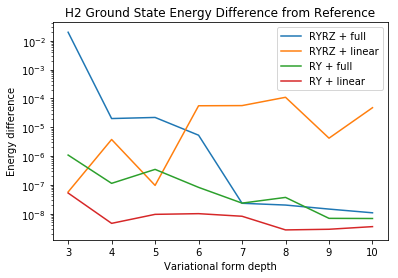

In [3]:
for k in range(len(var_forms)):
    for j in range(len(entanglements)):
        pylab.plot(depths, energies[k][j]-energy, label=var_forms[k]+' + '+entanglements[j])
pylab.xlabel('Variational form depth')
pylab.ylabel('Energy difference')
pylab.yscale('log')
pylab.title('H2 Ground State Energy Difference from Reference')
pylab.legend(loc='upper right')

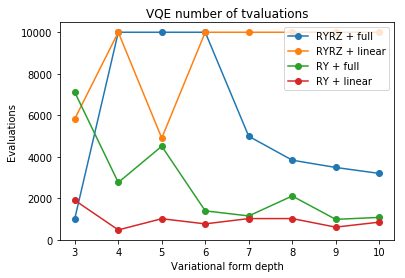

In [4]:
for k in range(len(var_forms)):
    for j in range(len(entanglements)):
        pylab.plot(depths, eval_counts[k][j], '-o', label=var_forms[k]+' + '+entanglements[j])
pylab.xlabel('Variational form depth')
pylab.ylabel('Evaluations')
pylab.title('VQE number of evaluations')
pylab.legend(loc='upper right')